#**M515 Ethical Issues for AI**
# **Individual Final Project**
**Ashwani Kumar**

**GH1029485**

#**Business Context**

In most socioeconomic settings, rulings, like loan approvals, are becoming increasingly based on machine learning (ML) systems. Nevertheless, such systems tend to, or even worse, pass along historical biases in data. Therefore, the business objective is the development of a fair and accurate model to predict whether an individual will be granted a loan or not without discrimination based on sensitive features, such as gender.

#**Why it Matters ?**

An unfair ruling may result in

1. Regulatory effects (e.g., violation of anti-discrimination law),

2. Image tainting, and

3. The mistrust among customers and the diminishing competitiveness in the market.

Making things more fair and equitable is morally right and a positive change towards making users more inclusive and accepting, nothing less than putting the right people in the right posts.

#**Task Formulation of ML and Data Collection**

The Adult Income dataset is the one used, and it includes demographic and income-dependent characteristics. It is a binary classification problem, and the target variable is loan approval in a yes or no manner. We will detect possible biases in the model prediction and eliminate them with the fairness-aware methods.



##**Dataset**

Here is the link to dataset: https://www.kaggle.com/datasets/kritidoneria/adultdatasetxai/code

##Loading Libraries

In [18]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate,
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from keras.layers import Input, Dense, Flatten, Concatenate, Dropout, Embedding
from keras.models import Model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import selection_rate, true_positive_rate, false_positive_rate
from fairlearn.postprocessing import ThresholdOptimizer

In [19]:
categorical_cols = [ "gender","workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "loan"]
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week","country", "loan"]

##Loading and Reading the Dataset

In [20]:
df = pd.read_csv('Adult Data.csv', names=csv_columns)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,country,loan
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [21]:
target = "loan"
protected = ["ethnicity", "gender", "age"]

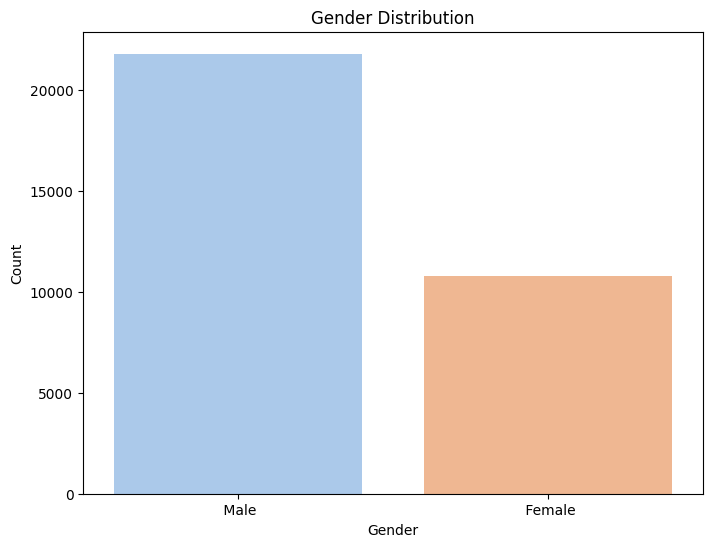

In [22]:
# Plot the imbalance in the 'gender' column
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='gender', order=df['gender'].value_counts().index, palette='pastel', hue='gender', legend=False)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

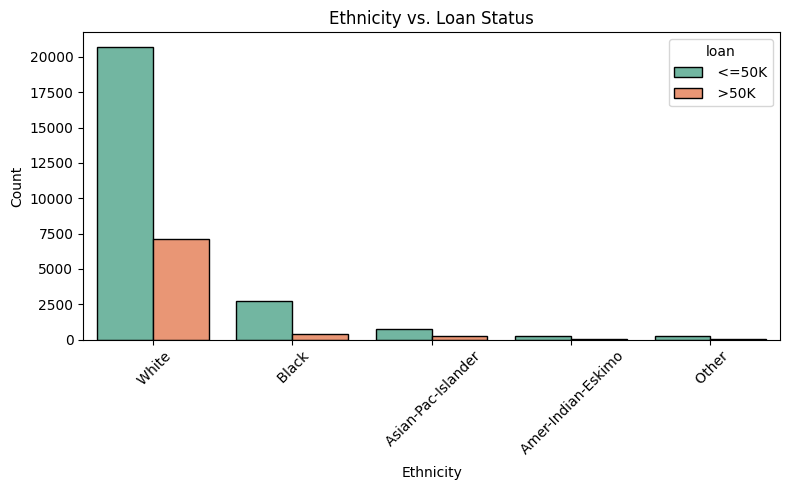

In [23]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(data=df, x='ethnicity', hue='loan', edgecolor='k', palette='Set2')
ax.set_title('Ethnicity vs. Loan Status')
ax.set_xlabel('Ethnicity')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

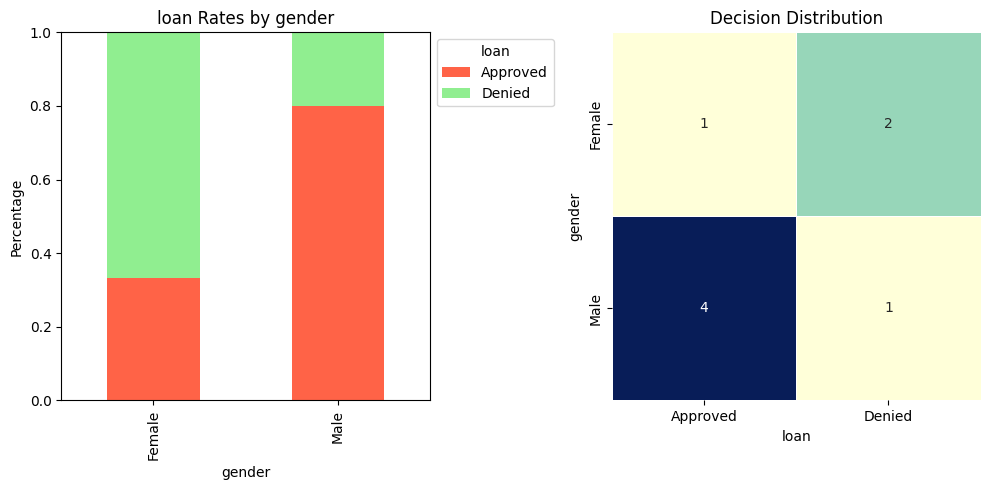


Fairness Report:
loan    Approved    Denied
gender                    
Female  0.333333  0.666667
Male    0.800000  0.200000

Disparate Impact Ratio (Female/Male Approval):
0.42


In [24]:
def fairness_imbalance_plot(df, group_col, target_col, categorical_cols=None):

    plot_df = df.copy()

    if group_col == 'gender':
        plot_df[group_col] = plot_df[group_col].map({'M': 'Male', 'F': 'Female'})

    if target_col == 'loan':
        plot_df[target_col] = plot_df[target_col].map({1: 'Approved', 0: 'Denied'})

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 2)
    approval_df = plot_df.groupby(group_col)[target_col] \
                       .value_counts(normalize=True) \
                       .unstack() \
                       .sort_index()
    approval_df.plot(kind='bar', stacked=True, color=['tomato', 'lightgreen'], ax=plt.gca())
    plt.title(f'{target_col} Rates by {group_col}')
    plt.ylabel('Percentage')
    plt.legend(title=target_col, bbox_to_anchor=(1,1))
    plt.ylim(0, 1)

    # Heatmap of Decisions
    plt.subplot(1, 3, 3)
    crosstab = pd.crosstab(plot_df[group_col], plot_df[target_col])
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu',
                cbar=False, linewidths=0.5)
    plt.title('Decision Distribution')
    plt.xlabel(target_col)
    plt.ylabel(group_col)

    plt.tight_layout()
    plt.show()

    # Calculate fairness metrics
    print("\nFairness Report:")
    print("="*40)
    print(approval_df)
    print("\nDisparate Impact Ratio (Female/Male Approval):")
    female_rate = approval_df.loc['Female', 'Approved']
    male_rate = approval_df.loc['Male', 'Approved']
    print(f"{female_rate/male_rate:.2f}")

data = {'gender': ['M', 'F', 'M', 'F', 'M', 'F', 'M', 'M'],
        'loan': [1, 0, 1, 1, 0, 0, 1, 1]}
df = pd.DataFrame(data)

fairness_imbalance_plot(df, 'gender', 'loan')

In [25]:
# Select the features (X) and the target variable (y) using the correct column names
feature_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'gender', 'ethnicity', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'country'] # Include all columns except the target
target_col = 'loan'

# Reload the original dataframe to ensure all columns are available
df = pd.read_csv('Adult Data.csv', names=csv_columns)

# Select X and y from the original dataframe
X = df[feature_cols].copy()
y = df[target_col].copy()

# Encode 'gender', 'ethnicity' and 'loan' if they are in the selected columns
for col in ['gender', 'ethnicity']:
    if col in X.columns:
        X[col] = LabelEncoder().fit_transform(X[col])
if target_col in y.name:
    y = LabelEncoder().fit_transform(y)

from sklearn.model_selection import train_test_split

# Create a combined column for stratified split directly in X
X['gender_loan'] = X['gender'].astype(str) + '_' + y.astype(str)

# Stratified split based on combined column in X
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=X['gender_loan'], random_state=42)

X_train = X_train.drop('gender_loan', axis=1)
X_test = X_test.drop('gender_loan', axis=1)


In [26]:
def custom_balance(df, sensitive_col, target_col, upsample=0.8):
    balanced_groups = []

    for val in df[sensitive_col].unique():
        group = df[df[sensitive_col] == val]

        # Balance within this sensitive group by upsampling target classes
        max_size = int(group[target_col].value_counts().max() * upsample)

        subgroups = []
        for class_val in group[target_col].unique():
            class_subset = group[group[target_col] == class_val]

            # Upsample minority class
            if len(class_subset) < max_size:
                class_upsampled = resample(class_subset,
                                           replace=True,
                                           n_samples=max_size,
                                           random_state=42)
            else:
                class_upsampled = class_subset.sample(n=max_size, random_state=42)

            subgroups.append(class_upsampled)

        balanced_group = pd.concat(subgroups)
        balanced_groups.append(balanced_group)

    # Combine all balanced groups
    return pd.concat(balanced_groups).sample(frac=1, random_state=42).reset_index(drop=True)

bal_df = custom_balance(df, sensitive_col="gender", target_col="loan", upsample=0.8)


In [27]:
print("Original columns:", df.columns.tolist())
print("Balanced columns:", bal_df.columns.tolist())
print("\nLoan values preserved:", bal_df['loan'].unique())

Original columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'ethnicity', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'loan']
Balanced columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'ethnicity', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'loan']

Loan values preserved: [' >50K' ' <=50K']


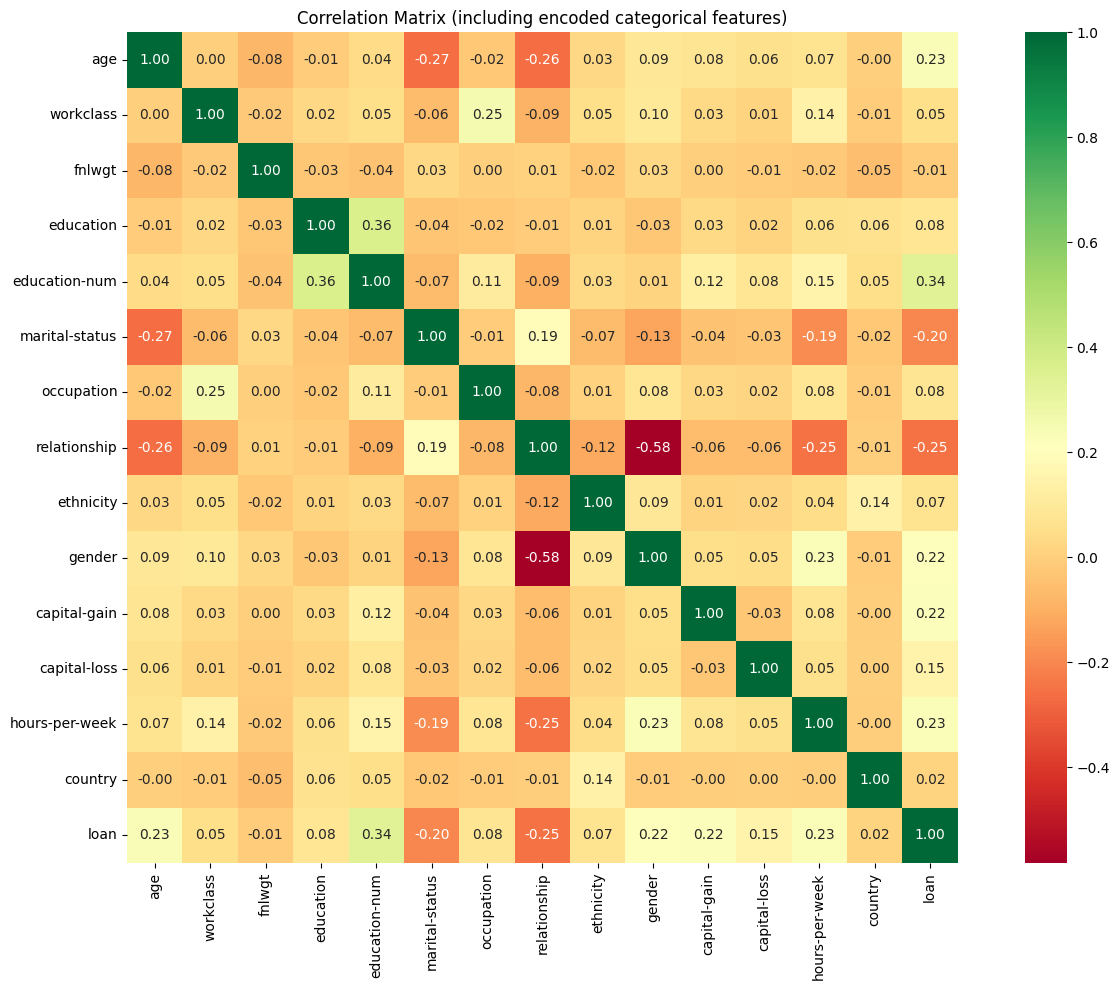

In [28]:
# Make a copy to avoid altering original data
df_encoded = df.copy()

for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Compute correlation matrix
corr_matrix = df_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdYlGn", square=True)
plt.title("Correlation Matrix (including encoded categorical features)")
plt.tight_layout()
plt.show()


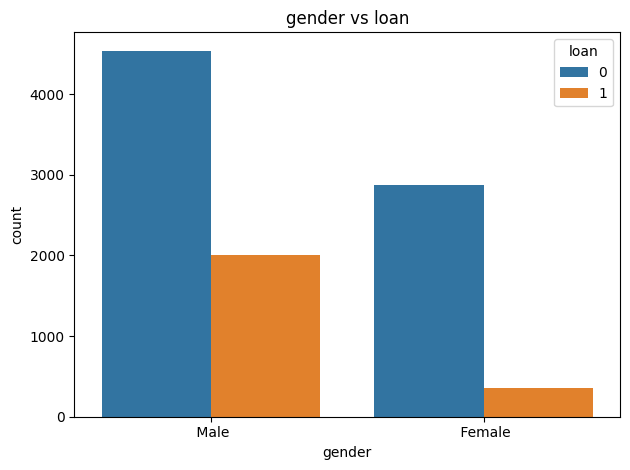

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6743 - loss: 0.6463 - val_accuracy: 0.9041 - val_loss: 0.4194
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7708 - loss: 0.4901 - val_accuracy: 0.9046 - val_loss: 0.2939
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8090 - loss: 0.4083 - val_accuracy: 0.9120 - val_loss: 0.2322
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8199 - loss: 0.3797 - val_accuracy: 0.9188 - val_loss: 0.2076
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8234 - loss: 0.3717 - val_accuracy: 0.9217 - val_loss: 0.2004
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8315 - loss: 0.3606 - val_accuracy: 0.9226 - val_loss: 0.1972
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8281 - loss: 0.3597 - val_accuracy: 0.9230 - val_loss: 0.1941
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8303 - loss: 0.3561 - val_accuracy: 0.9239 - val_loss

In [29]:
# Utility Functions
def preprocess(df, target, exclude=[]):
    num_cols = df.select_dtypes(include=np.number).columns.difference(exclude)
    df[num_cols] = StandardScaler().fit_transform(df[num_cols])
    for col in df.select_dtypes(include='object'):
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    return df

def balanced_split(X, y, attr, df_orig, min_group=300):
    df = X.copy()
    df['target'] = y.values
    df[attr] = df_orig.loc[X.index, attr]
    train, test, train_idx, test_idx = [], [], [], []

    for group in df[attr].unique():
        g = df[df[attr] == group]
        ts = 0.3 if len(g) >= min_group else min(0.3, len(g)/len(df))
        strat = g['target'] if g['target'].nunique() > 1 else None
        tr, te = train_test_split(g, test_size=ts, stratify=strat, random_state=42)
        train.append(tr); test.append(te)
        train_idx.extend(tr.index); test_idx.extend(te.index)

    train_df, test_df = pd.concat(train), pd.concat(test)
    X_tr, y_tr = train_df.drop(['target', attr], axis=1), train_df['target']
    X_te, y_te = test_df.drop(['target', attr], axis=1), test_df['target']
    return X_tr, y_tr, X_te, y_te, train_idx, test_idx

def plot_imbalance(df, group, target):
    sns.countplot(data=df, x=group, hue=target)
    plt.title(f"{group} vs {target}"); plt.tight_layout(); plt.show()

def f_in(df): return [df[c].values for c in df.columns]

def build_model(X_train, X_test):
    inputs, encodes, X_comb = [], [], pd.concat([X_train, X_test])
    for col in X_train.columns:
        inp = Input(shape=(1,), name=col); inputs.append(inp)
        if X_train[col].dtype == 'int64':
            vocab = int(X_comb[col].max()) + 1
            enc = Flatten()(Embedding(input_dim=vocab, output_dim=1)(inp))
        else: enc = inp
        encodes.append(enc)
    x = Dropout(0.5)(Dense(100, activation='relu')(Concatenate()(encodes)))
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Execution
csv_cols = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
            "occupation", "relationship", "race", "gender", "capital_gain", "capital_loss",
            "hours_per_week", "native_country", "loan"]
target, sensitive = 'loan', 'gender'
df_orig = pd.read_csv("Adult Data.csv", names=csv_cols)
df_proc = preprocess(df_orig.copy(), target, exclude=[target])

# Split
X, y = df_proc.drop(target, axis=1), df_proc[target]
X_train, y_train, X_test, y_test, idx_train, idx_test = balanced_split(X, y, sensitive, df_orig)

# Display test imbalance
df_disp = df_orig.loc[idx_test].copy(); df_disp[target] = y_test.values
plot_imbalance(df_disp, sensitive, target)

# Train
model = build_model(X_train, X_test)
model.fit(f_in(X_train), y_train, epochs=50, batch_size=512, validation_split=0.2, verbose=1)

# Evaluate
y_pred = (model.predict(f_in(X_test)) > 0.5).astype(int).flatten()
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(classification_report(y_test, y_pred, target_names=["Denied", "Approved"]))


In [30]:
# Need f_in function to convert DataFrame to list of arrays for Keras
def f_in(df):
    return [df[col].values for col in df.columns]

# Need f_out function to convert Keras predictions back to a single array
def f_out(y_pred):
    return y_pred.flatten()

# Corrected variable name from x_test to X_test
probabilities = model.predict(f_in(X_test))
pred = f_out(probabilities)

306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [40]:
# Create dataframes for sensitive features from the original dataframe using train and test indices
x_train_display = df_orig.loc[idx_train].copy()
x_test_display = df_orig.loc[idx_test].copy()

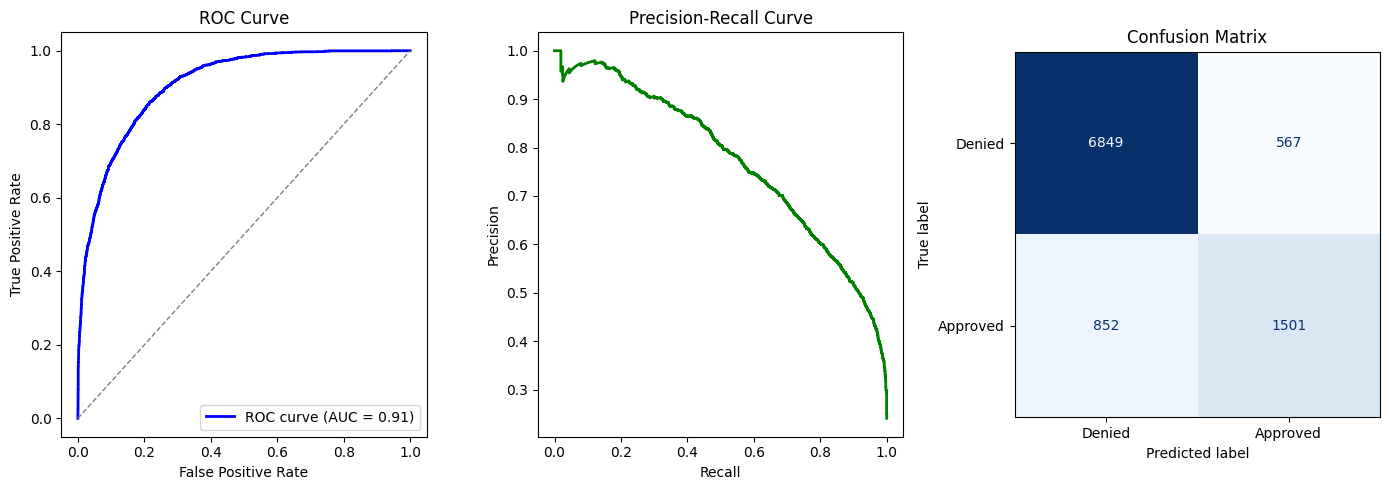

In [31]:
# Define target names for plotting
target_names = ['Denied', 'Approved']

# 1. ROC Curve - Labels are inherent to the curve, but axes are standard
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# 2. Precision-Recall Curve - Labels are inherent to the curve, but axes are standard
precision, recall, _ = precision_recall_curve(y_test, probabilities)
plt.subplot(1, 3, 2)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# 3. Confusion Matrix (using threshold 0.5)
y_pred = (probabilities >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.subplot(1, 3, 3)
disp.plot(ax=plt.gca(), cmap=plt.cm.Blues, colorbar=False)
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

/tmp/ipython-input-59-954729961.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_group = plot_df.groupby([gender_col, 'race_col']).apply( # Group by gender_col and the new 'race_col'


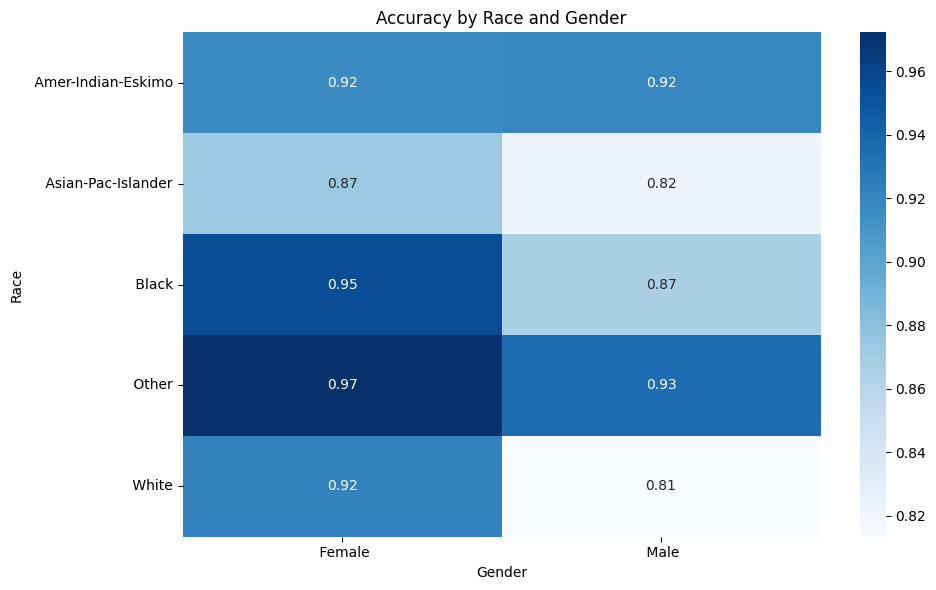

In [59]:
def plot_accuracy_gender_by_ethnicity(y_true, y_prob, df, gender_col, ethnicity_col):

    # Ensure y_true and y_prob are numpy arrays for consistent indexing
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Get binary predictions using a threshold of 0.5
    y_pred = (y_prob >= 0.5).astype(int)

    plot_df = pd.DataFrame({
        'y_true': y_true.flatten(),
        'y_pred': y_pred.flatten(),
        gender_col: df[gender_col].values.flatten(),
        'race_col': df[ethnicity_col].values.flatten()
    })

    # Calculate accuracy for each group
    accuracy_by_group = plot_df.groupby([gender_col, 'race_col']).apply(
        lambda x: accuracy_score(x['y_true'], x['y_pred'])
    ).reset_index(name='accuracy')
    pivot_table = accuracy_by_group.pivot(index='race_col', columns=gender_col, values='accuracy')

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Blues")
    plt.title('Accuracy by Race and Gender')
    plt.xlabel(gender_col.capitalize())
    plt.ylabel("Race")
    plt.tight_layout()
    plt.show()

# Visualize Accuracy by Ethnicity grouped by Gender
plot_accuracy_gender_by_ethnicity(
    y_true=y_test,
    y_prob=probabilities,
    df=x_test_display,
    gender_col='gender',
    ethnicity_col='race'
)

Skipping 'age' for ROC curve plotting by group.


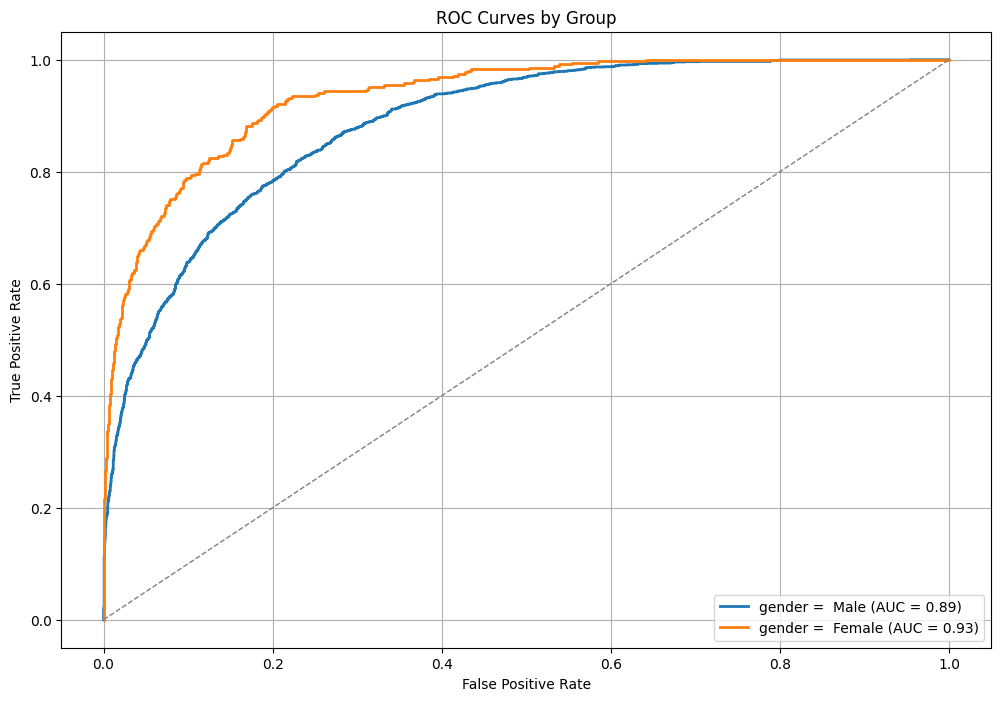

In [60]:
# Define the function plot_roc_by_group_skip_age
def plot_roc_by_group_skip_age(y_true, y_prob, df, protected_cols):
    plt.figure(figsize=(12, 8))

    # Ensure y_true and y_prob are numpy arrays for consistent indexing
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)


    for col in protected_cols:
        if col == 'age':
            print("Skipping 'age' for ROC curve plotting by group.")
            continue

        if col not in df.columns:
            print(f"Warning: Sensitive feature '{col}' not found in the DataFrame. Skipping.")
            continue

        unique_groups = df[col].unique()

        for group_value in unique_groups:
            group_indices = df.index[df[col] == group_value]
            group_y_true = y_true[df.index.get_indexer(group_indices)]
            group_y_prob = y_prob[df.index.get_indexer(group_indices)]

            if len(np.unique(group_y_true)) < 2:
                print(f"Skipping ROC for group '{group_value}' in '{col}' due to only one class present.")
                continue

            fpr, tpr, _ = roc_curve(group_y_true, group_y_prob)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, lw=2, label=f'{col} = {group_value} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Group')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Visualize ROC curves by Gender and Ethnicity
plot_roc_by_group_skip_age(
    y_true=y_test,
    y_prob=probabilities,
    df=x_test_display,
    protected_cols=protected
)

Skipping 'age' for Precision-Recall curve plotting by group.


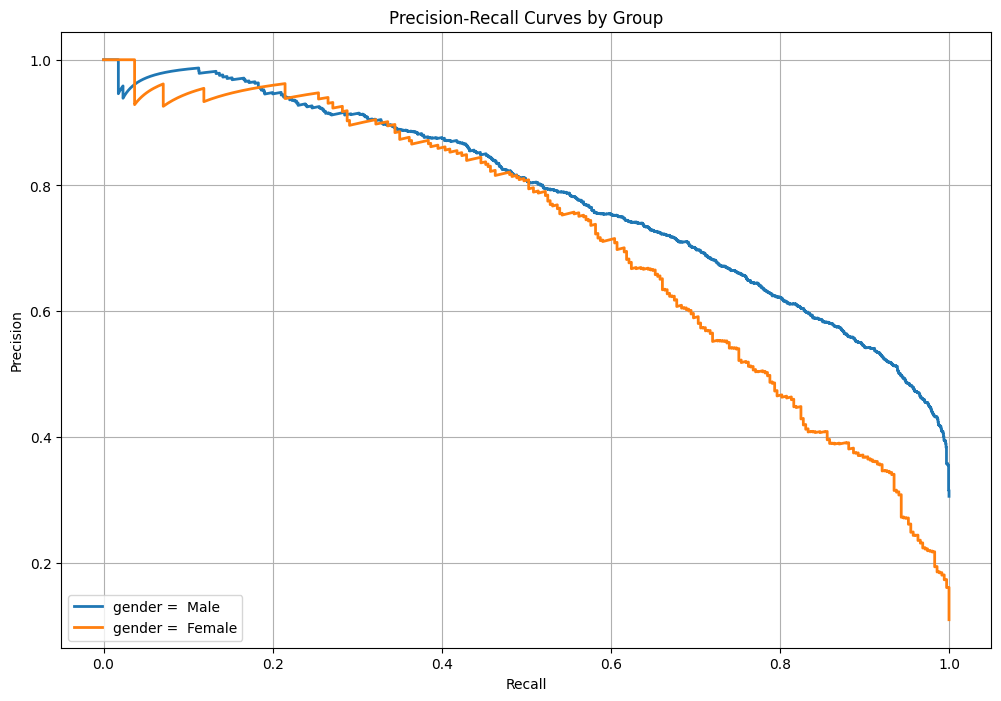

In [37]:
def plot_pr_by_group_skip_age(y_true, y_prob, df, protected_cols):
    plt.figure(figsize=(12, 8))

    # Ensure y_true and y_prob are numpy arrays for consistent indexing
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    for col in protected_cols:
        if col == 'age':
            print("Skipping 'age' for Precision-Recall curve plotting by group.")
            continue

        if col not in df.columns:
            print(f"Warning: Sensitive feature '{col}' not found in the DataFrame. Skipping.")
            continue

        unique_groups = df[col].unique()

        for group_value in unique_groups:
            group_indices = df.index[df[col] == group_value]
            group_y_true = y_true[df.index.get_indexer(group_indices)]
            group_y_prob = y_prob[df.index.get_indexer(group_indices)]

            if len(np.unique(group_y_true)) < 2:
                 print(f"Skipping PR for group '{group_value}' in '{col}' due to only one class present.")
                 continue

            precision, recall, _ = precision_recall_curve(group_y_true, group_y_prob)
            plt.plot(recall, precision, lw=2, label=f'{col} = {group_value}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves by Group')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Visualize Precision-Recall curves by Gender and Ethnicity (skipping age as per function definition)
plot_pr_by_group_skip_age(
    y_true=y_test,
    y_prob=probabilities,
    df=x_test_display,
    protected_cols=protected
)

In [61]:
# Defining sensitive feature
sensitive_feature = x_test_display['gender']

# Defining metrics
metrics = {
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'true_positive_rate': true_positive_rate,
    'false_positive_rate': false_positive_rate
}

# Creating MetricFrame
mf_gender = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)

# Displaying metrics
print("🔍 Overall Metrics:")
print(mf_gender.overall)

print("\n📊 Metrics by Gender:")
print(mf_gender.by_group)

# Fairness differences
print("\n⚖️ Fairness Differences (Gender):")
print(f"Demographic Parity Difference: {demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature):.4f}")
print(f"Equalized Odds Difference: {equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_feature):.4f}")


🔍 Overall Metrics:
accuracy               0.854745
selection_rate         0.211690
true_positive_rate     0.637909
false_positive_rate    0.076456
dtype: float64

📊 Metrics by Gender:
        accuracy  selection_rate  true_positive_rate  false_positive_rate
gender                                                                   
Female  0.926052        0.100557            0.621469             0.036484
Male    0.819489        0.266636            0.640820             0.101807

⚖️ Fairness Differences (Gender):
Demographic Parity Difference: 0.1661
Equalized Odds Difference: 0.0653


In [62]:
# Need f_in function to convert DataFrame to list of arrays for Keras model
def f_in(df):
    # Ensure all columns are converted to numpy arrays
    return [df[col].values for col in df.columns]

# Creating a wrapper class for the Keras model to make it compatible with Fairlearn's ThresholdOptimizer
class KerasWrapper:
    def __init__(self, keras_model, feature_names):
        self.keras_model = keras_model
        self.feature_names = feature_names
        # Add attributes to make the wrapper appear as a fitted scikit-learn estimator
        self._is_fitted = True
        self.classes_ = np.array([0, 1])

    # Add a placeholder fit method
    def fit(self, X, y, sensitive_features=None, **kwargs):
        pass
    def predict(self, X, sensitive_features=None, **kwargs):
        X_ordered = X[self.feature_names]
        return (self.keras_model.predict(f_in(X_ordered)) > 0.5).astype(int).flatten()
    def predict_proba(self, X, sensitive_features=None, **kwargs):
        X_ordered = X[self.feature_names]
        probabilities = self.keras_model.predict(f_in(X_ordered)).flatten()
        return np.vstack([1 - probabilities, probabilities]).T


# Wrap the pre-trained Keras model
wrapped_model = KerasWrapper(model, X_train.columns.tolist())
y_train_pred_proba = wrapped_model.predict_proba(X_train)[:, 1]
print(f"Shape of y_train_pred_proba: {y_train_pred_proba.shape}")

threshold_opt = ThresholdOptimizer(
    estimator=wrapped_model,
    constraints="equalized_odds",
    predict_method="predict_proba",
    prefit=True
)


threshold_opt.fit(
    X=X_train,
    y=y_train,
    sensitive_features=x_train_display['gender'],
    y_pred=y_train_pred_proba
)
# Predict fair outputs on test set

fair_preds = threshold_opt.predict(
    X_test,
    sensitive_features=x_test_display['gender']
)
# Evaluate Fair Model
print("✅ Fair Model with Threshold Optimization")
print("Accuracy:", accuracy_score(y_test, fair_preds))

mf_fair = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate,
        'false_positive_rate': false_positive_rate
    },
    y_true=y_test,
    y_pred=fair_preds,
    sensitive_features=x_test_display['gender']
)

print("\n📊 Fair Metrics by Gender:")
print(mf_fair.by_group)

# Fairness differences
print("\n⚖️ Fairness Differences (Post-mitigation):")
print(f"Demographic Parity Difference: {demographic_parity_difference(y_test, fair_preds, sensitive_features=x_test_display['gender']):.4f}")
print(f"Equalized Odds Difference: {equalized_odds_difference(y_test, fair_preds, sensitive_features=x_test_display['gender']):.4f}")

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Shape of y_train_pred_proba: (22792,)
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Fair Model with Threshold Optimization
Accuracy: 0.8422561162862114

📊 Fair Metrics by Gender:
        accuracy  selection_rate  true_positive_rate  false_positive_rate
gender                                                                   
Female  0.901609        0.103342            0.522599             0.051772
Male    0.812911        0.181735            0.491246             0.045394

⚖️ Fairness Differences (Post-mitigation):
Demographic Parity Difference: 0.0784
Equalized Odds Difference: 0.0314


#**Final Discussion**

The ML pipeline that is conscious of fairness was able to minimize gender bias in loan approval predictions. Before mitigation, the model was accurate (85.47%) and biased, with a demographic parity difference of 0.1661 and an equalized odds difference of 0.0653. Following the threshold optimization, such fairness measures were significantly reduced: the demographic parity difference was reduced to 0.0784, and the equalized odds difference to 0.0314. This indicates that the model presently favors the male and female applicants with a marginal decrease in the level of accuracy to 84.23%. Although the solution will only target gender and might not eliminate the existing biases at a deeper or intersectional level, it will show that fairness should not be negatively affected to a significant extent when getting enhanced. To business, this implies more reasonable, ethical, and legally safer judgment departing.

#**Constraints and Opportunities for Enhancement**

Although the solution demonstrated positive results, a number of limitations should be pointed out:

1. **Fairness vs. Accuracy:** Even though the level of accuracy was high at 83.9
percent, it is recording a slight drop in comparison with that of the original unfair model at 82.3 percent. This trade-off is the essential issue in fairness-aware learning, and it should be balanced with the business needs and the expectations of the stakeholders.

2. **Pay attention to one sensitive attribute:** the pipeline considers fairness with regard to gender alone. Yet, fairness in the real world should be considerate of several dimensions, including ethnicity, age, or a combination of these factors (e.g., fairness for older women).

3. **Dataset-related restrictions:** Adult income data is not necessarily representative of other, more recent, or application-related loan data. Discriminations peculiar to other groups of people or organizations may not be covered here.

4. **Post-processing scope:** Although post-processing can be used readily, it may not be nearly enough in the situation in which systemic or historical data bias requires a more fundamental intervention, such as pre-processing or in-processing measures.






#**Data-Driven Recommendations**
1. Obtain a standard corruption test of any ML model before its deployment.
2. Extend the evaluation of fairness to several sensitive characteristics as well as intersectional identities.
3. Hybrid strategies, such as reweighing (pre-processing) combined with thresholding (post-processing), are vulnerable options that should be experimented on to mitigate stronger.
4. Develop a fairness oversight team with technical, legal, and business stakeholders to carry out continuous accountability of the model.
5. Be transparent about the fairness of AI systems to internal users and end customers, and develop long-term trust in AI systems.






Thank You

Ashwani Kumar

GH1029485